#Cancer Detection Using Convolutional Neural Networks (CNNs)

##Library Imports

In [ ]:
# Dataset
import kagglehub

# Basic data manipulation and visualization
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Deep learning imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Random functions
import random

seed = 100
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

##Data Structure


In [ ]:
# Download latest version of the dataset
path = kagglehub.dataset_download("lesliedalton/breast-cancer-grade")
BASE_PATH = path

# Define paths with correct nested structure
tcga_path = os.path.join(BASE_PATH, 'Folder_1_TCGA_train_images', 'Folder_1_TCGA_train_images')
chtn_path = os.path.join(BASE_PATH, 'Folder_2_CHTN_train_images', 'Folder_2_CHTN_train_images')

print("Dataset paths:")
print(f"TCGA path: {tcga_path}")
print(f"CHTN path: {chtn_path}")

# Function to check folder contents
def print_folder_contents(folder_path):
    try:
        contents = os.listdir(folder_path)
        print(f"\nContents of {os.path.basename(folder_path)}:")
        for item in contents:
            item_path = os.path.join(folder_path, item)
            if os.path.isdir(item_path):
                num_files = len([f for f in os.listdir(item_path)
                               if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif', '.tiff'))])
                print(f"- {item}: {num_files} images")
    except Exception as e:
        print(f"Error reading directory: {str(e)}")

# Check contents of both datasets
print("\nExamining TCGA dataset:")
print_folder_contents(tcga_path)

print("\nExamining CHTN dataset:")
print_folder_contents(chtn_path)

# Print the first few files in each folder to verify contents
def print_sample_files(folder_path, n=3):
    print(f"\nSample files in {os.path.basename(folder_path)}:")
    for subdir in os.listdir(folder_path):
        subdir_path = os.path.join(folder_path, subdir)
        if os.path.isdir(subdir_path):
            files = [f for f in os.listdir(subdir_path)
                    if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif', '.tiff'))]
            print(f"\n{subdir}:")
            for f in files[:n]:
                print(f"  - {f}")

print("\nSample files from TCGA:")
print_sample_files(tcga_path)

print("\nSample files from CHTN:")
print_sample_files(chtn_path)

100%|██████████| 334M/334M [00:18<00:00, 19.2MB/s]

Extracting files...


Dataset paths:
TCGA path: /root/.cache/kagglehub/datasets/lesliedalton/breast-cancer-grade/versions/1/Folder_1_TCGA_train_images/Folder_1_TCGA_train_images
CHTN path: /root/.cache/kagglehub/datasets/lesliedalton/breast-cancer-grade/versions/1/Folder_2_CHTN_train_images/Folder_2_CHTN_train_images

Examining TCGA dataset:

Contents of Folder_1_TCGA_train_images:
- High: 4323 images
- Stroma: 3088 images
- Low: 3542 images

Examining CHTN dataset:

Contents of Folder_2_CHTN_train_images:
- High: 5191 images
- Stroma: 2928 images
- Low: 5222 images

Sample files from TCGA:

Sample files in Folder_1_TCGA_train_images:

High:
  - TCGA-BH-A1F6___82.jpg
  - TCGA-E2-A14N___240.jpg
  - TCGA-E9-A243___159.jpg

Stroma:
  - Screenshot (4749)_8_0.jpg
  - Screenshot (3321)_2_0.jpg
  - Screenshot (2121)_1_1.jpg

Low:
  - Screenshot (4375)_6_1.jpg
  - Screenshot (2192)_6_1.jpg
  - Screenshot (2927)_2_0.jpg

Sample files from CHTN:

Sample files in Folder_2_CHTN_train_images:

High:
  - nci130.jpg
  - r

##Loading Files

In [ ]:
# Define correct nested paths
TCGA_PATH = os.path.join(BASE_PATH, 'Folder_1_TCGA_train_images', 'Folder_1_TCGA_train_images')
CHTN_PATH = os.path.join(BASE_PATH, 'Folder_2_CHTN_train_images', 'Folder_2_CHTN_train_images')

# Print dataset statistics
categories = ['High', 'Low', 'Stroma']
dataset_stats = {
    'TCGA': {cat: len(os.listdir(os.path.join(TCGA_PATH, cat))) for cat in categories},
    'CHTN': {cat: len(os.listdir(os.path.join(CHTN_PATH, cat))) for cat in categories}
}

print("Dataset Statistics:")
print("\nTCGA Dataset:")
for category, count in dataset_stats['TCGA'].items():
    print(f"{category}: {count} images")

print("\nCHTN Dataset:")
for category, count in dataset_stats['CHTN'].items():
    print(f"{category}: {count} images")

total_images = sum(dataset_stats['TCGA'].values()) + sum(dataset_stats['CHTN'].values())
print(f"\nTotal images in dataset: {total_images}")

Dataset Statistics:

TCGA Dataset:
High: 4323 images
Low: 3542 images
Stroma: 3089 images

CHTN Dataset:
High: 5191 images
Low: 5223 images
Stroma: 2928 images

Total images in dataset: 24296


Sample Images from TCGA Dataset:


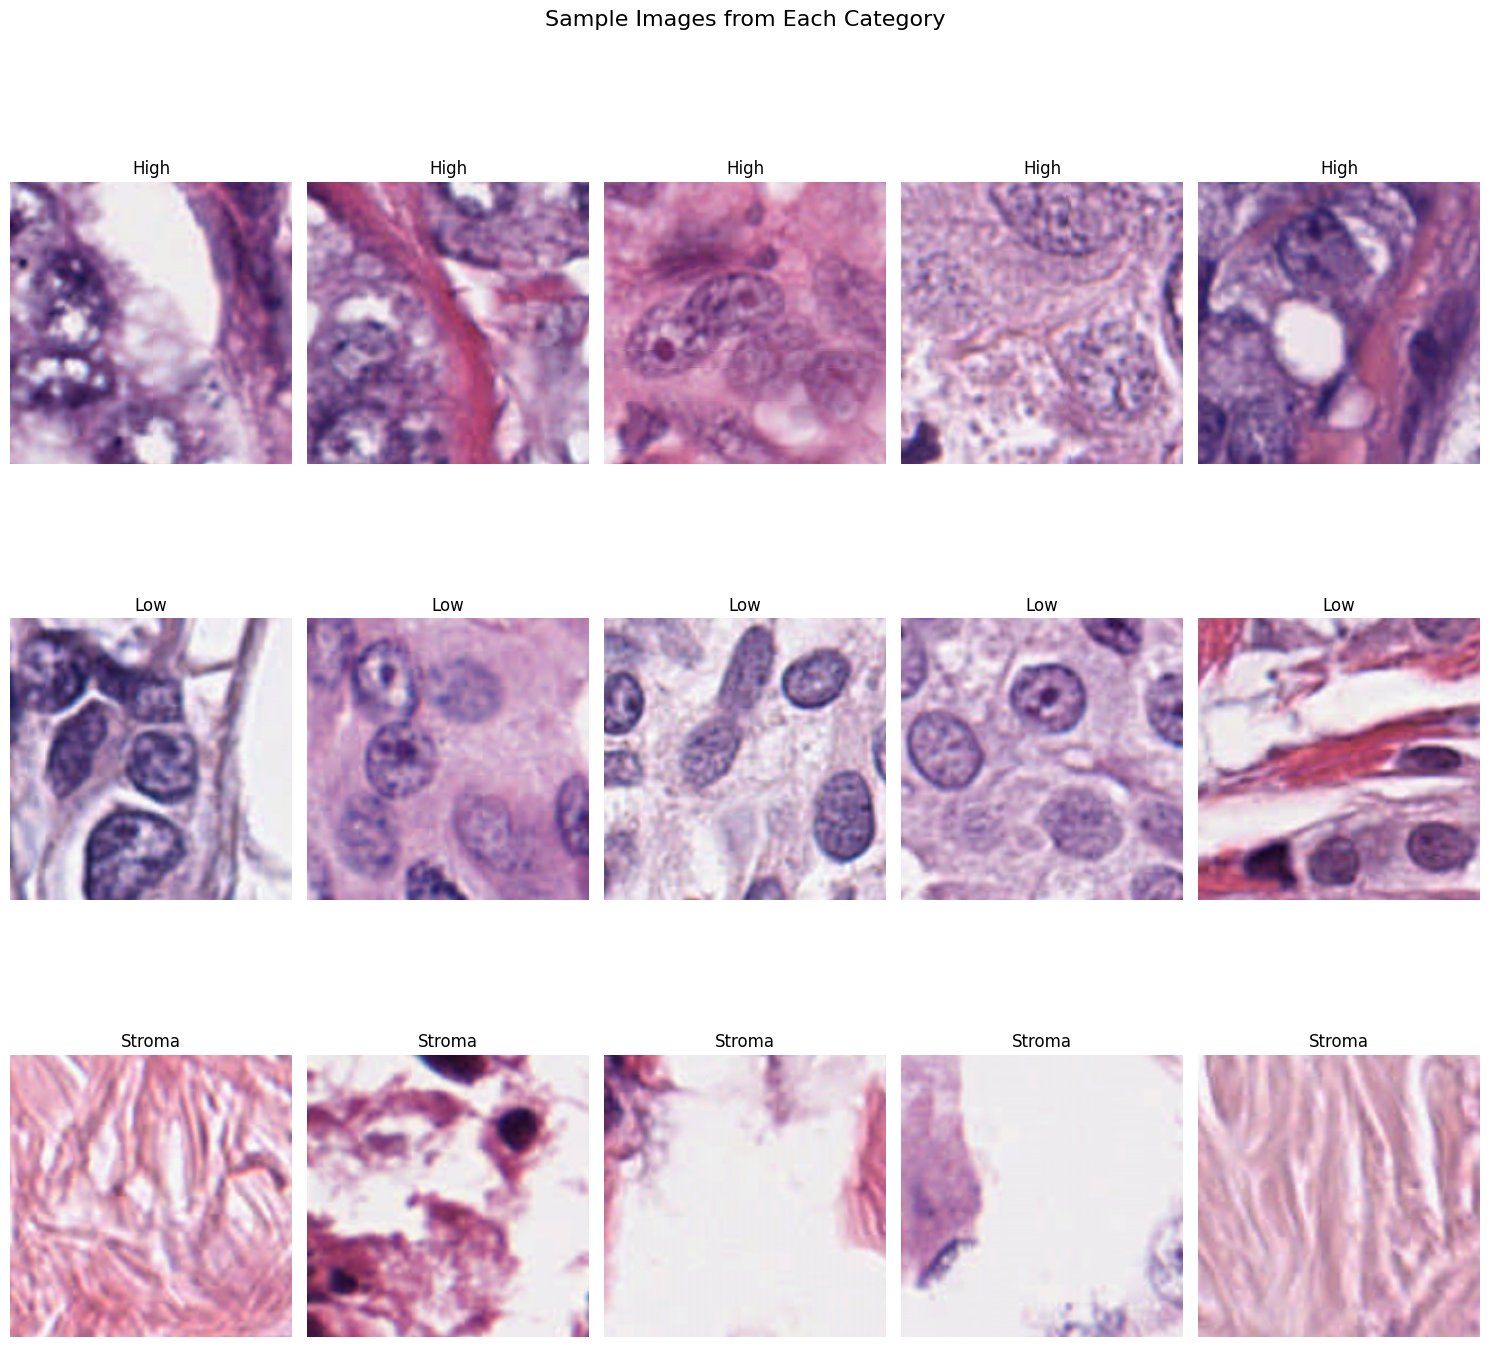

Sample Images from CHTN Dataset:


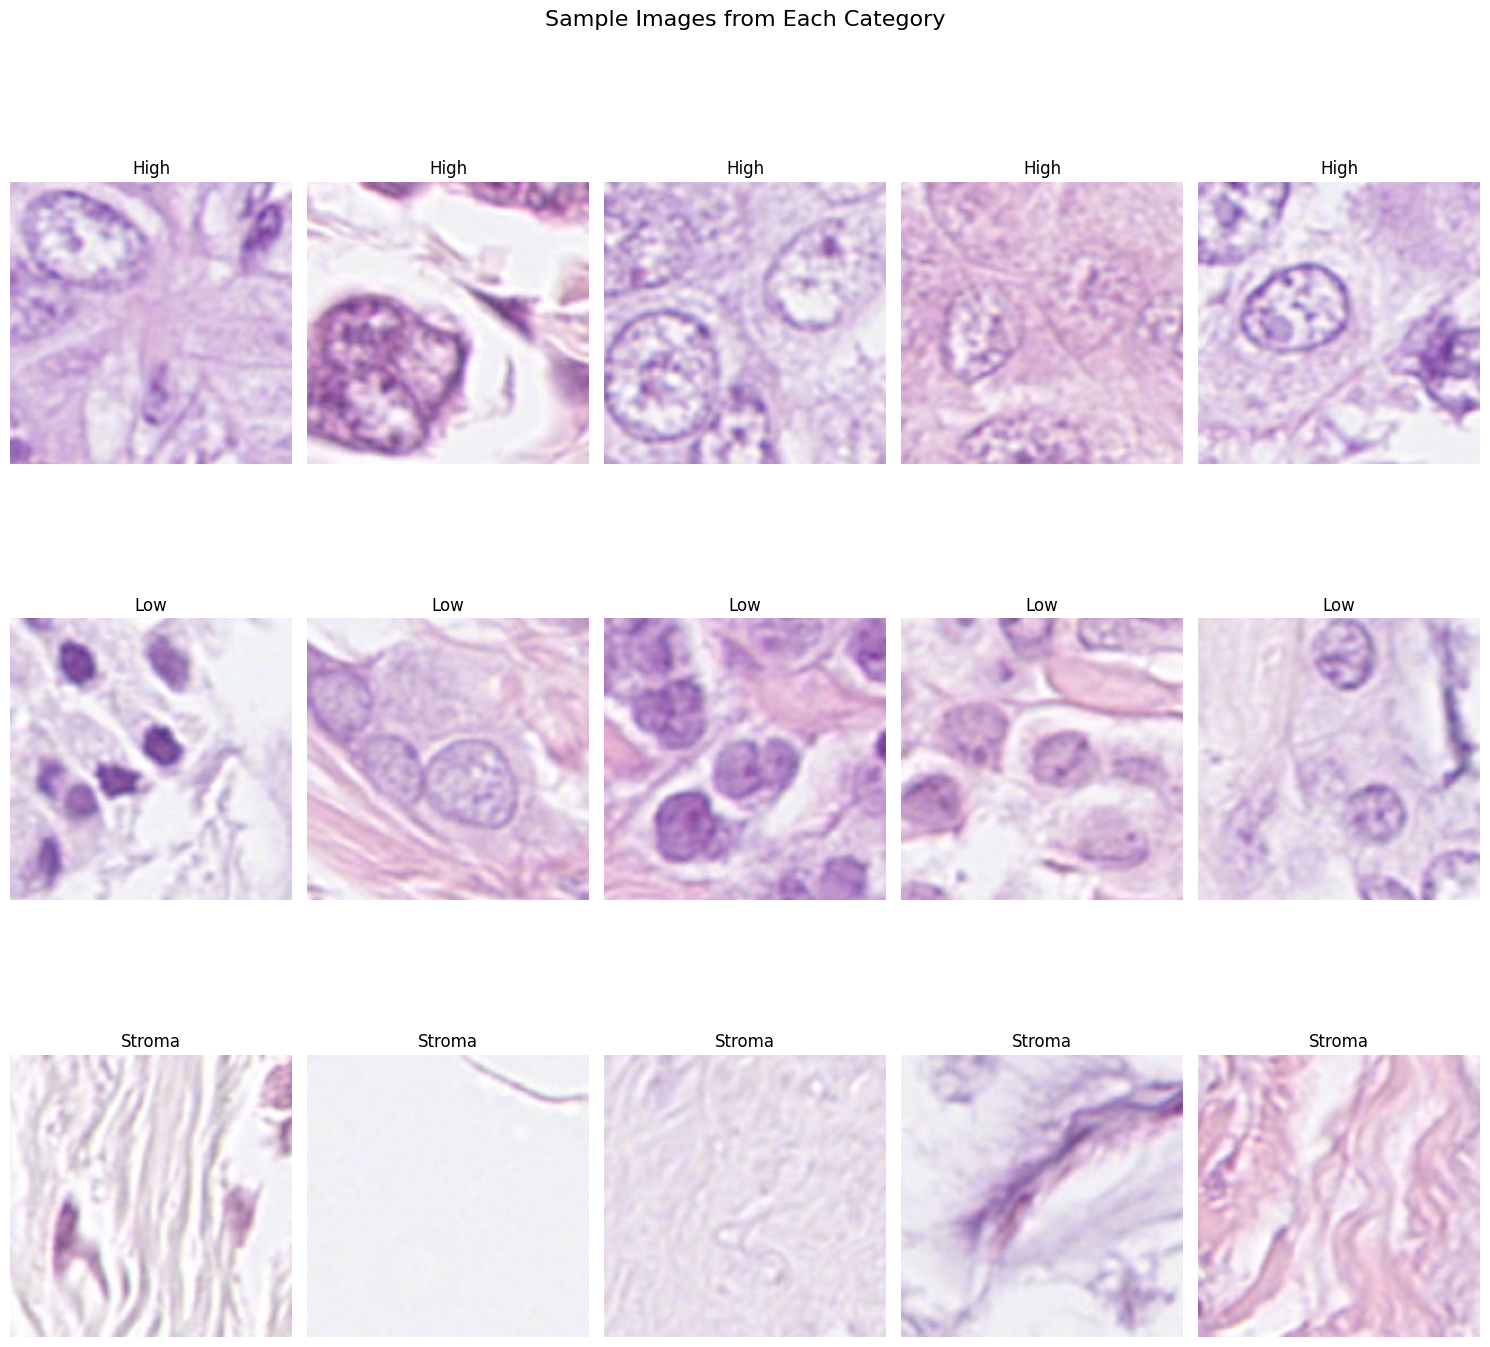

In [ ]:
def display_image_grid(base_path, categories, n_samples=5):
    """Display a grid of random images from each category for visual inspection."""
    fig, axes = plt.subplots(len(categories), n_samples, figsize=(15, 5 * len(categories)))
    fig.suptitle("Sample Images from Each Category", fontsize=16)

    for i, category in enumerate(categories):
        category_path = os.path.join(base_path, category)
        files = os.listdir(category_path)
        selected_files = random.sample(files, min(n_samples, len(files)))

        for j, file in enumerate(selected_files):
            file_path = os.path.join(category_path, file)
            img = Image.open(file_path)
            axes[i, j].imshow(img)
            axes[i, j].set_title(f"{category}")
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

# Display image grids for TCGA and CHTN datasets
print("Sample Images from TCGA Dataset:")
display_image_grid(TCGA_PATH, categories, n_samples=5)

print("Sample Images from CHTN Dataset:")
display_image_grid(CHTN_PATH, categories, n_samples=5)


In [ ]:
def plot_intensity_histograms(base_path, categories, n_samples=3):
    """Plot intensity histograms for RGB channels of random images in each category."""
    colors = ['r', 'g', 'b']

    for category in categories:
        category_path = os.path.join(base_path, category)
        files = os.listdir(category_path)
        selected_files = random.sample(files, min(n_samples, len(files)))

        plt.figure(figsize=(12, 4 * n_samples))
        plt.suptitle(f"RGB Intensity Histograms - {category}", fontsize=16)

        for i, file in enumerate(selected_files):
            file_path = os.path.join(category_path, file)
            img = Image.open(file_path).convert('RGB')
            img_array = np.array(img)

            plt.subplot(n_samples, 1, i + 1)
            for j, color in enumerate(colors):
                plt.hist(img_array[..., j].ravel(), bins=256, color=color, alpha=0.5, label=f'{color.upper()} channel')
            plt.legend(loc='upper right')
            plt.title(f"{category} - {file}")
            plt.xlabel("Pixel Intensity")
            plt.ylabel("Frequency")

        plt.tight_layout()
        plt.show()

# Display intensity histograms for TCGA and CHTN datasets
print("RGB Intensity Histograms for TCGA Dataset:")
plot_intensity_histograms(TCGA_PATH, categories, n_samples=3)

print("RGB Intensity Histograms for CHTN Dataset:")
plot_intensity_histograms(CHTN_PATH, categories, n_samples=3)


In [ ]:
def plot_image_size_distribution(base_path, categories):
    """Plot distribution of image sizes (width, height) across categories."""
    widths = []
    heights = []

    for category in categories:
        category_path = os.path.join(base_path, category)
        files = os.listdir(category_path)

        for file in files:
            file_path = os.path.join(category_path, file)
            try:
                img = Image.open(file_path)
                img.verify()
                img = Image.open(file_path)  # Reopen to get dimensions
                widths.append(img.size[0])
                heights.append(img.size[1])
            except (IOError, Image.UnidentifiedImageError):
                continue

    # Plot histograms for widths and heights
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=20, color='skyblue')
    plt.title('Image Width Distribution')
    plt.xlabel('Width (pixels)')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=20, color='salmon')
    plt.title('Image Height Distribution')
    plt.xlabel('Height (pixels)')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Display image size distribution for TCGA and CHTN datasets
print("Image Size Distribution for TCGA Dataset:")
plot_image_size_distribution(TCGA_PATH, categories)

print("Image Size Distribution for CHTN Dataset:")
plot_image_size_distribution(CHTN_PATH, categories)


##Preprocessing

In [ ]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    """Load and preprocess a single image"""
    try:
        img = Image.open(image_path)
        # Store original for visualization
        original = img.copy()

        # Preprocess
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img = img.resize(target_size)
        img_array = np.array(img) / 255.0

        return original, img_array
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        return None, None

def get_random_images(base_path, n_samples=10):
    """Get random images from each class"""
    images = []
    categories = ['High', 'Low', 'Stroma']

    for category in categories:
        category_path = os.path.join(base_path, category)
        files = os.listdir(category_path)
        # Get random files from this category
        selected_files = random.sample(files, min(n_samples // 3, len(files)))

        for file in selected_files:
            file_path = os.path.join(category_path, file)
            images.append((file_path, category))

    # Shuffle the selected images
    random.shuffle(images)
    return images[:n_samples]

# Create data generators for training
def create_data_generators(target_size=(224, 224), batch_size=32):
    """Create training and validation data generators"""
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        validation_split=0.3
    )

    # Print data augmentation settings
    print("\nData Augmentation Settings:")
    print("- Rotation range: ±20 degrees")
    print("- Width/Height shift: ±20%")
    print("- Horizontal and Vertical flips: Enabled")
    print("- Validation split: 20%")

    return datagen

def show_augmentation_examples(image_path, category, n_augmented=5):
    """Show examples of data augmentation for a single image"""
    # Load and preprocess image
    original, preprocessed = load_and_preprocess_image(image_path)

    if original is None or preprocessed is None:
        return

    # Create data generator
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True
    )

    # Generate augmented images
    preprocessed_batch = np.expand_dims(preprocessed, 0)
    aug_iter = datagen.flow(preprocessed_batch, batch_size=1)

    # Display original and augmented images
    plt.figure(figsize=(15, 3))

    # Original image
    plt.subplot(1, n_augmented + 1, 1)
    plt.imshow(preprocessed)
    plt.title(f'Original\n{category}')
    plt.axis('off')

    # Augmented images
    for i in range(n_augmented):
        plt.subplot(1, n_augmented + 1, i + 2)
        augmented = next(aug_iter)[0]
        plt.imshow(augmented)
        plt.title(f'Augmented {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Show augmentation examples for one image from each class
print("\nData Augmentation Examples:")
for category in ['High', 'Low', 'Stroma']:
    # Get a random image from the category
    category_path = os.path.join(TCGA_PATH, category)
    random_image = random.choice(os.listdir(category_path))
    image_path = os.path.join(category_path, random_image)

    print(f"\n{category} Grade Examples:")
    show_augmentation_examples(image_path, category)

# Create the data generators
datagen = create_data_generators()

print("\nPreprocessing pipeline is ready!")
print("- Images will be resized to 224x224")
print("- Pixel values will be normalized to [0,1]")
print("- Data augmentation is configured")
print("- Training/Validation split is set to 70/30")

Visualisations

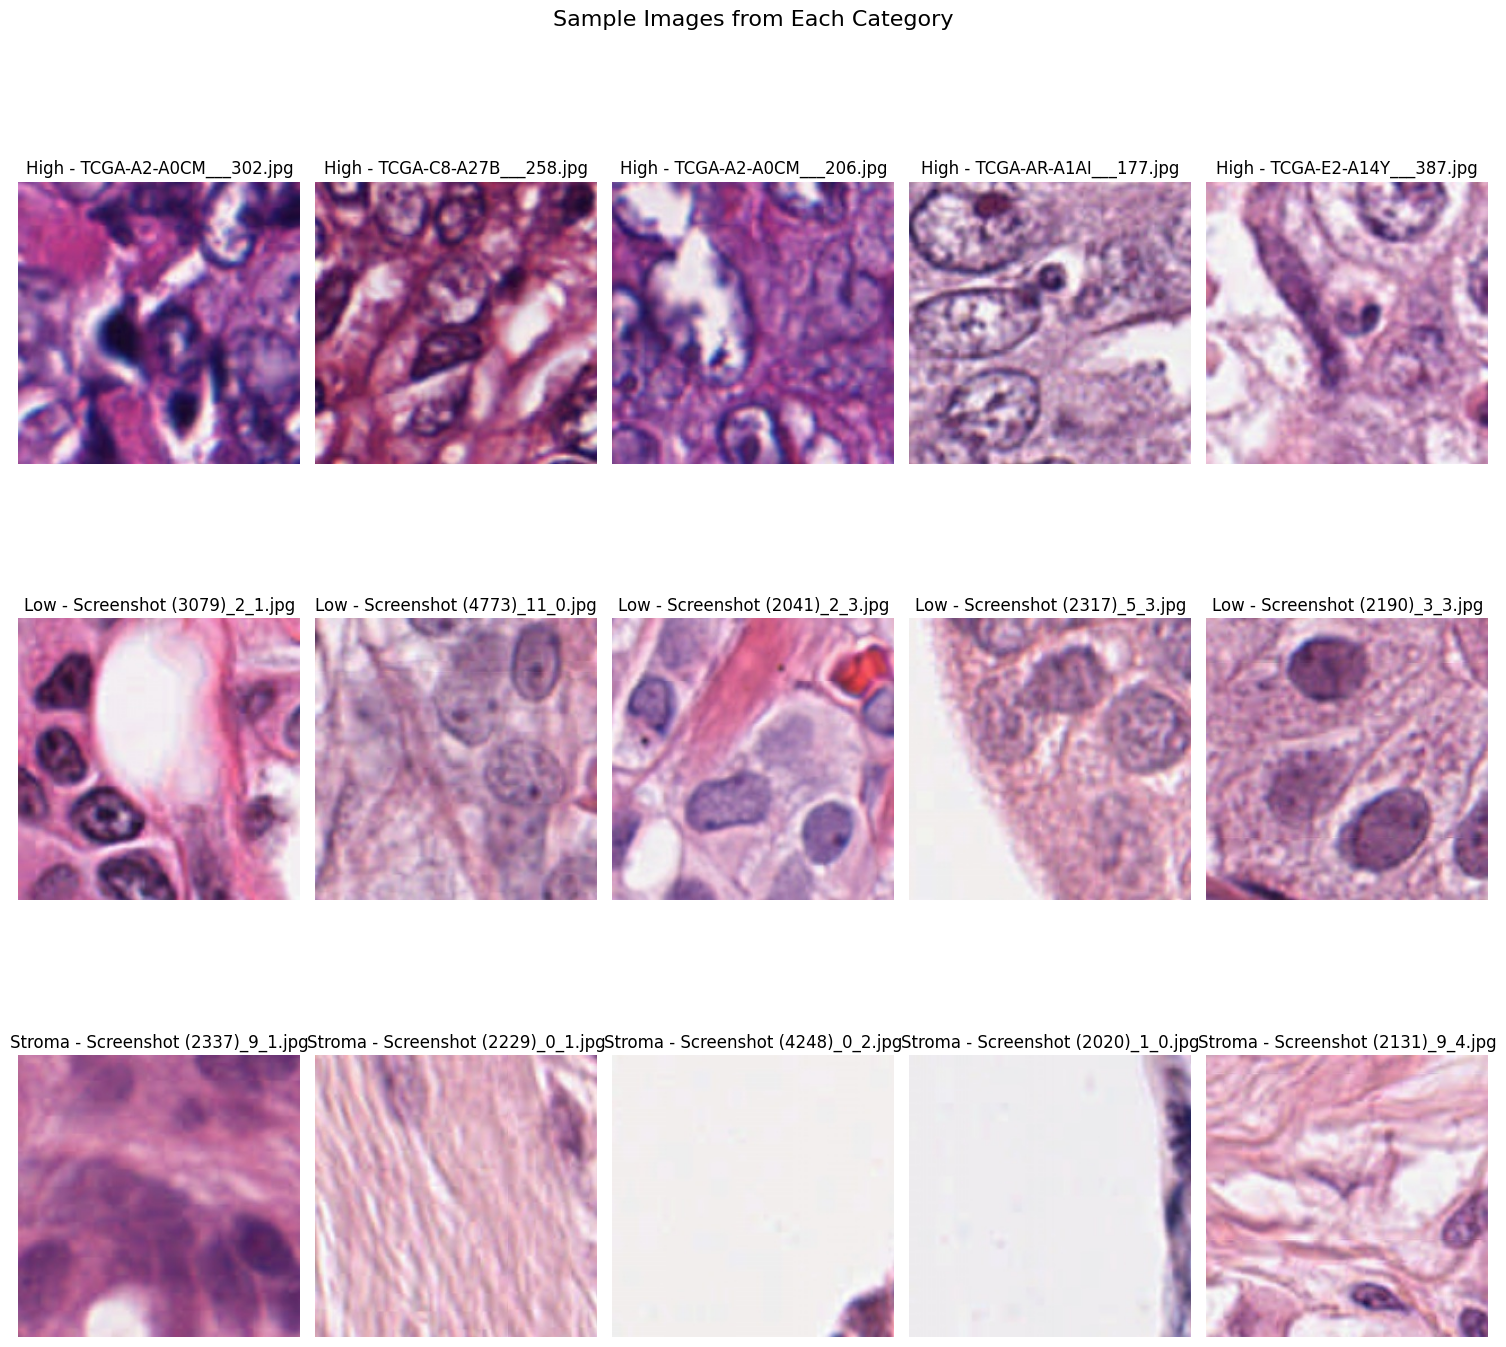

In [ ]:
def display_image_grid(base_path, categories, n_samples=5):
    """Display a grid of random images from each class for visual inspection."""
    fig, axes = plt.subplots(len(categories), n_samples, figsize=(15, 5 * len(categories)))
    fig.suptitle("Sample Images from Each Category", fontsize=16)

    for i, category in enumerate(categories):
        category_path = os.path.join(base_path, category)
        files = os.listdir(category_path)
        selected_files = random.sample(files, n_samples)

        for j, file in enumerate(selected_files):
            file_path = os.path.join(category_path, file)
            img = Image.open(file_path)
            axes[i, j].imshow(img)
            axes[i, j].set_title(f"{category} - {file}")
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

# Use this function with the TCGA path and categories
display_image_grid(TCGA_PATH, categories=['High', 'Low', 'Stroma'], n_samples=5)


In [ ]:
def plot_intensity_histograms(base_path, categories, n_samples=3):
    """Plot intensity histograms for RGB channels of random images in each category."""
    colors = ['r', 'g', 'b']

    for category in categories:
        category_path = os.path.join(base_path, category)
        files = os.listdir(category_path)
        selected_files = random.sample(files, n_samples)

        plt.figure(figsize=(12, 4 * n_samples))
        plt.suptitle(f"RGB Intensity Histograms - {category}", fontsize=16)

        for i, file in enumerate(selected_files):
            file_path = os.path.join(category_path, file)
            img = Image.open(file_path).convert('RGB')
            img_array = np.array(img)

            plt.subplot(n_samples, 1, i + 1)
            for j, color in enumerate(colors):
                plt.hist(img_array[..., j].ravel(), bins=256, color=color, alpha=0.5, label=f'{color.upper()} channel')
            plt.legend(loc='upper right')
            plt.title(f"{category} - {file}")


Model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Create the CNN model using Functional API
def create_cnn_model():
    inputs = tf.keras.Input(shape=(224, 224, 3), name='input')
    x = Conv2D(32, (3, 3), activation='relu', name='conv_1')(inputs)
    x = MaxPooling2D((2, 2), name='maxpool_1')(x)
    x = Conv2D(64, (3, 3), activation='relu', name='conv_2')(x)
    x = MaxPooling2D((2, 2), name='maxpool_2')(x)
    x = Conv2D(128, (3, 3), activation='relu', name='conv_3')(x)
    x = MaxPooling2D((2, 2), name='maxpool_3')(x)
    x = Flatten(name='flatten')(x)
    x = Dense(128, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.01),
              name='dense_1')(x)
    x = Dropout(0.5, name='dropout')(x)
    outputs = Dense(3, activation='softmax', name='output')(x)
    model = Model(inputs=inputs, outputs=outputs, name='cnn_model')
    return model

# Compile and train the CNN model
def train_cnn_model(train_generator, validation_generator):
    model = create_cnn_model()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    print("\nCNN Model Summary:")
    model.summary()

    # Train the model with early stopping
    callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=30,
        callbacks=callbacks
    )

    # Save the trained model
    model.save('breast_cancer_cnn_model.keras')
    print("\nCNN model trained and saved as 'breast_cancer_cnn_model.keras'")
    return model

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('breast_cancer_cnn_model (1).keras')

# Evaluate the model on a validation or test generator
eval_result = model.evaluate(validation_generator)
print(f"Validation Loss: {eval_result[0]:.4f}, Validation Accuracy: {eval_result[1]:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


103/103 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.7858 - loss: 0.5833
Validation Loss: 0.6346, Validation Accuracy: 0.7250


In [ ]:
# Generate predictions for a batch of data
predictions = model.predict(validation_generator)


103/103 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step


In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# Define a new input layer with the same shape as the model's input
input_layer = Input(shape=(224, 224, 3))

# Pass this input through the existing model's layers
x = input_layer
for layer in model.layers:
    x = layer(x)

# Create a new model from the input layer to the desired output layer
feature_extractor = Model(inputs=input_layer, outputs=x)

# Now you can use feature_extractor to get features
features = feature_extractor.predict(validation_generator)

103/103 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step


In [ ]:
# Assuming `validation_generator` has been used to extract features
labels = []
for _, batch_labels in validation_generator:
    labels.extend(np.argmax(batch_labels, axis=1))  # Convert one-hot to label index
    if len(labels) >= len(features):  # Stop if we have all labels needed
        labels = labels[:len(features)]  # Make sure length matches features
        break

In [ ]:
from collections import Counter

# Count the occurrences of each label
label_counts = Counter(labels)
print("Label Distribution:", label_counts)


Label Distribution: Counter({0: 1296, 1: 1062, 2: 926})


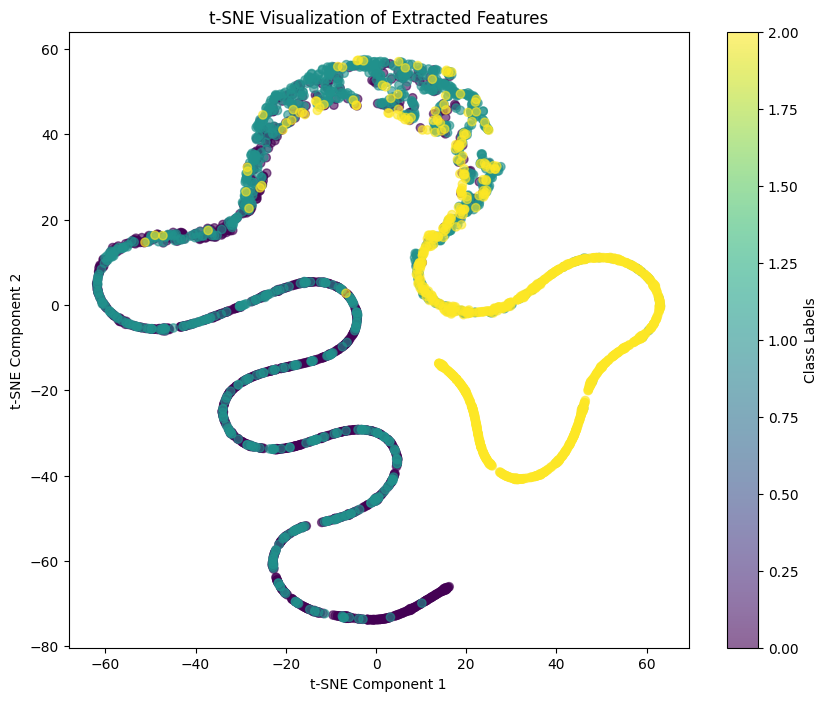

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Perform t-SNE on the extracted features
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

# Plot the results with the class labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Class Labels')
plt.title("t-SNE Visualization of Extracted Features")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


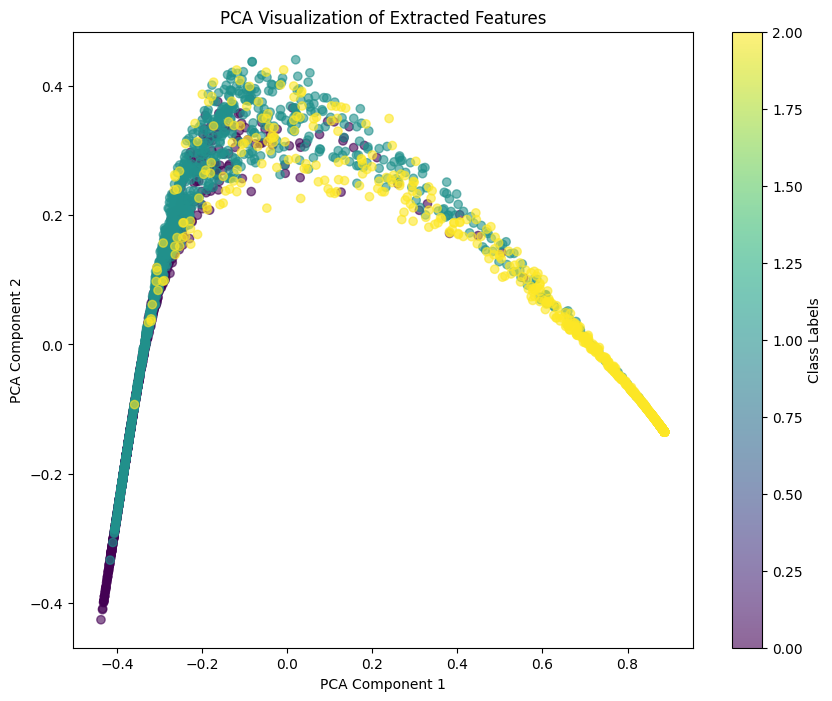

In [ ]:
from sklearn.decomposition import PCA

# Perform PCA on the extracted features
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)

# Plot the results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Class Labels')
plt.title("PCA Visualization of Extracted Features")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Split the features and labels into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# Predict on the validation set
y_pred = classifier.predict(X_val)

# Evaluate the classifier
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))


Validation Accuracy: 0.6880

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.71      0.72       293
           1       0.54      0.54      0.54       208
           2       0.81      0.84      0.82       156

    accuracy                           0.69       657
   macro avg       0.69      0.70      0.69       657
weighted avg       0.69      0.69      0.69       657



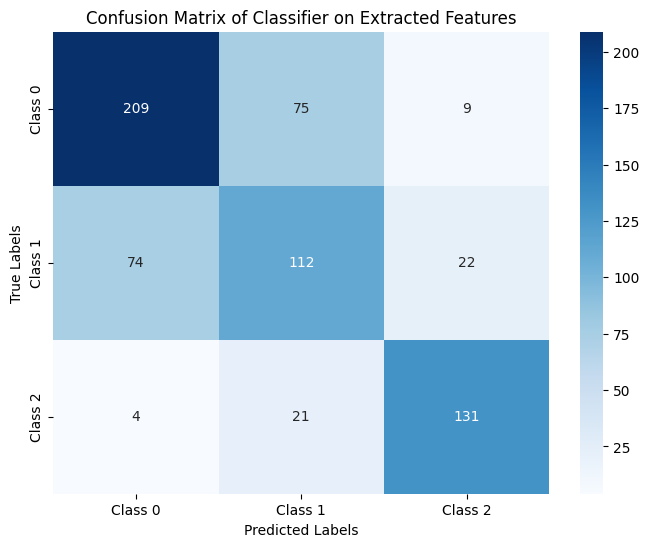

In [ ]:
from sklearn.metrics import confusion_matrix  # Import confusion_matrix
import seaborn as sns

# Define class labels
class_labels = ["Class 0", "Class 1", "Class 2"]

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix of Classifier on Extracted Features")
plt.show()
